In [1]:
import quanguru as qg
import numpy as np
import matplotlib.pyplot as plt

In [2]:
numOfQubits = 5
freequency = 1
freeOperator = qg.Jz
couplingStrength = 1*2*np.pi

In [3]:
nQubExchange = numOfQubits * qg.Qubit(frequency=freequency, operator=freeOperator)
nQubHeisenberg = numOfQubits * qg.Qubit(frequency=freequency, operator=freeOperator)

In [4]:
exchangeCouplings = []
qubs = list(nQubExchange.subSys.values())
for ind in range(numOfQubits-1):
    s = [qubs[ind], qubs[ind+1]]
    exchangeCouplings.append(nQubExchange.createTerm(operator=[qg.sigmax, qg.sigmax], frequency=0, qSystem=s))
    exchangeCouplings.append(nQubExchange.createTerm(operator=[qg.sigmay, qg.sigmay], frequency=0, qSystem=s))

In [5]:
HeisenbergCouplingObjs = []
qubs = list(nQubHeisenberg.subSys.values())
for ind in range(numOfQubits-1):
    s = [qubs[ind], qubs[ind+1]]
    HeisenbergCouplingObjs.append(nQubHeisenberg.createTerm(operator=[qg.sigmax, qg.sigmax], frequency=couplingStrength,
                                                            qSystem=s))
    HeisenbergCouplingObjs.append(nQubHeisenberg.createTerm(operator=[qg.sigmay, qg.sigmay], frequency=couplingStrength,
                                                            qSystem=s))
    HeisenbergCouplingObjs.append(nQubHeisenberg.createTerm(operator=[qg.sigmaz, qg.sigmaz], frequency=couplingStrength,
                                                            qSystem=s))

In [6]:
protocol = qg.qProtocol(superSys=nQubExchange)

s1 = qg.freeEvolution(superSys=nQubExchange)
qubits = list(nQubExchange.subSys.values())

interactionSteps = []
ind = 0
while ind in range(len(exchangeCouplings)):
    u1 = qg.freeEvolution(superSys=nQubExchange)
    u1.createUpdate(system=[exchangeCouplings[ind], exchangeCouplings[ind+1]], key='frequency',
                            value=couplingStrength/2)
    u1.createUpdate(system=qubits, key='frequency', value=0)
    interactionSteps.append(u1)
    ind += 2


xRots = [qg.xGate(system=qubits, angle=np.pi/2, rotationAxis='x'), 
         qg.xGate(system=qubits, angle=-np.pi/2, rotationAxis='x')]
yRots = [qg.xGate(system=qubits, angle=np.pi/2, rotationAxis='y'), 
         qg.xGate(system=qubits, angle=-np.pi/2, rotationAxis='y')]

sequence = ('f', 'xy', 'xz', 'yz')
for st in sequence:
    if st == 'f':
        protocol.addStep(s1)
    elif st == 'xy':
        protocol.addStep(*interactionSteps)
    elif st == 'xz':
        protocol.addStep(xRots[0])
        protocol.addStep(*interactionSteps)
        protocol.addStep(xRots[1])
    elif st == 'yz':
        protocol.addStep(yRots[0])
        protocol.addStep(*interactionSteps)
        protocol.addStep(yRots[1])

In [7]:
stepSizes = [0.001, 0.2]
freqValues = [0.1*i for i in range(50)]
totalSimTimeV = 5

sigmaZ = qg.compositeOp(qg.sigmaz(), 2**(numOfQubits-1))

def compute(qsim, args):
    res = qsim.qRes

    res.result = 'state fidelity', qg.fidelityPure(args[0], args[1])

    for key, _ in qsim.subSys.items():
        res.result = [key.name.name+'Exp', qg.expectation(sigmaZ, key.currentState)]

simulation = qg.Simulation()
simulation.initialStateSystem = nQubHeisenberg
simulation.initialState = [0 if x < 1 else 1 for x in range(numOfQubits)]
simulation.delStates = True

simulation.addSubSys(nQubExchange, protocol)
simulation.addSubSys(nQubHeisenberg)

simulation.compute = compute
simulation.totalTime = totalSimTimeV
simulation.stepSize = stepSizes[0]

#stepSizeSweep = simulation.Sweep.createSweep(system=simulation, sweepKey='stepSize', sweepList=stepSizes)
freqSweep = simulation.Sweep.createSweep(system=[exchangeCouplings, HeisenbergCouplingObjs], sweepKey='frequency', sweepList=freqValues)

In [8]:
simulation.run(p=True)

[]

In [9]:
res = simulation.results

Text(0, 0.5, 'Time')

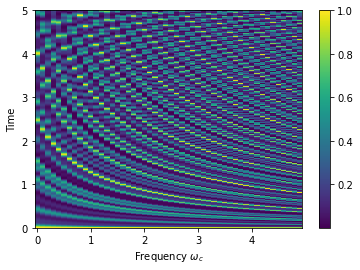

In [10]:
Y, X = np.meshgrid(simulation.timeList, freqSweep.sweepList)

plt.pcolormesh(X, Y, simulation.results['state fidelity'])
plt.colorbar()

plt.xlabel("Frequency $\omega_{c}$")
plt.ylabel("Time")

In [11]:
# plt.plot([i*stepSizes[0] for i in range(len(res['state fidelity'][0]))], res['state fidelity'][0], 'r-', label=f'$\\tau = {stepSizes[0]}$')
# plt.plot([i*stepSizes[1] for i in range(len(res['state fidelity'][1]))], res['state fidelity'][1], 'b-', label=f'$\\tau = {stepSizes[1]}$')
# plt.legend()